In [2]:
import numpy as np
from scipy import integrate
from scipy.special import k0

### $\widetilde{\mathcal{I}}_{\mathcal{V}_(c)+(d)}(z,x_{01})$

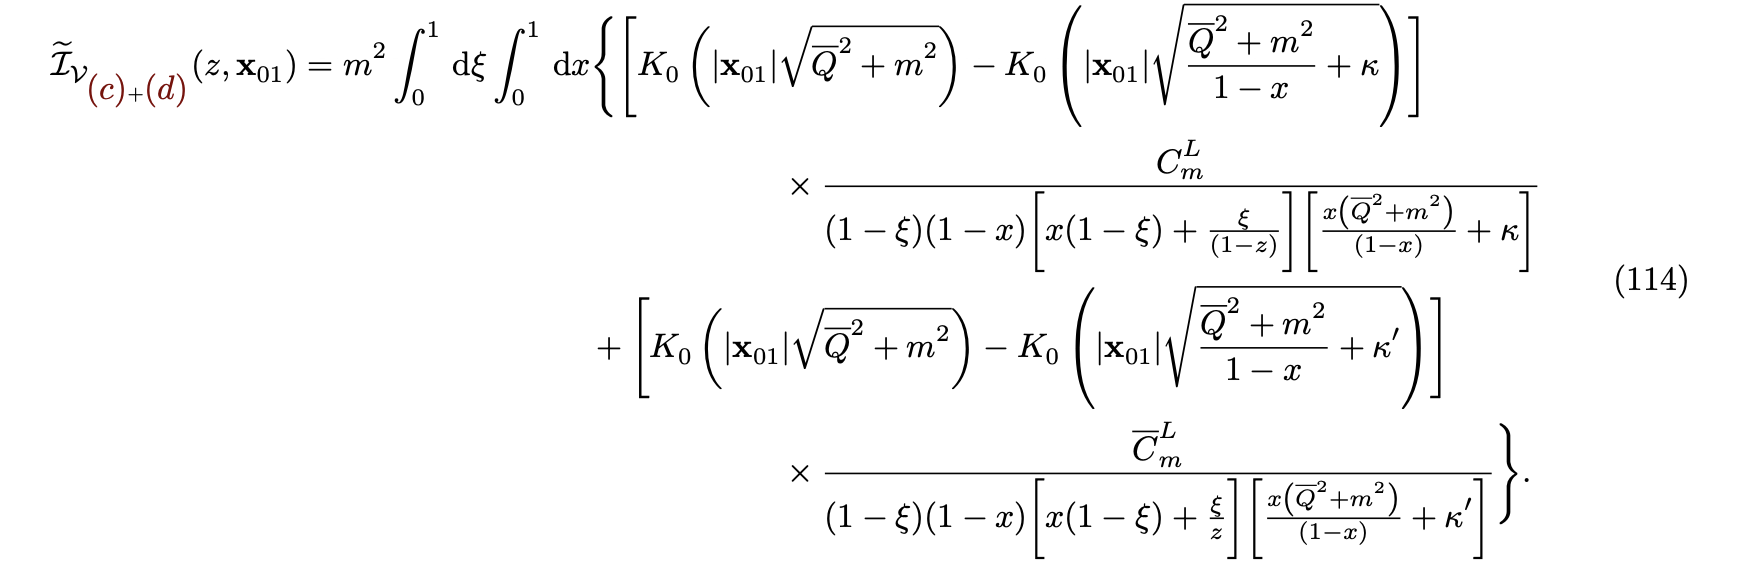
https://arxiv.org/pdf/2103.14549 (114)

Note: this test case, as well as the C++ code, also includes a prefactor 
$$4  Q^2 z^2 (1-z)^2 K_0(\epsilon r)$$

In [13]:
# ------------------------------------------------------------
# Coefficient functions: Eqs. (97) and (89)
# ------------------------------------------------------------

def C_m_L(z, x, xi):
    # Eq. (97)
    return (z**2 * (1 - xi) / (1 - z)) * (
        -xi**2
        + x * (1 - xi)
        * (1 + (1 - xi) * (1 + z * xi / (1 - z)))
        / (x * (1 - xi) + xi / (1 - z))
    )


def Cbar_m_L(z, x, xi):
    # Eq. (89)
    return ((1 - z)**2 * (1 - xi) / z) * (
        -xi**2
        + x * (1 - xi)
        * (1 + (1 - xi) * (1 + (1 - z) * xi / z))
        / (x * (1 - xi) + xi / z)
    )

# ------------------------------------------------------------
# Kappa functions: Eq. (115)
# ------------------------------------------------------------

def kappa(z, x, xi, m):
    num = xi * m**2
    den = (1 - xi) * (1 - x) * (x * (1 - xi) + xi / (1 - z))
    bracket = xi * (1 - x) + x * (1 - z * (1 - xi) / (1 - z))
    return num / den * bracket


def kappa_prime(z, x, xi, m):
    num = xi * m**2
    den = (1 - xi) * (1 - x) * (x * (1 - xi) + xi / z)
    bracket = xi * (1 - x) + x * (1 - (1 - z) * (1 - xi) / z)
    return num / den * bracket

# ------------------------------------------------------------
# Integrand of Eq. (114)
# ------------------------------------------------------------

def integrand_Icd(x, xi, z, r, Q2, m):
    Qm2 = z*(1-z)*Q2 + m**2

    kap = kappa(z, x, xi, m)
    kapp = kappa_prime(z, x, xi, m)

    pref = m**2 / ((1 - xi) * (1 - x))

    term1 = (
        k0(r * np.sqrt(Qm2))
        - k0(r * np.sqrt(Qm2 / (1 - x) + kap))
    )

    term2 = (
        k0(r * np.sqrt(Qm2))
        - k0(r * np.sqrt(Qm2 / (1 - x) + kapp))
    )

    denom1 = (x * (1 - xi) + xi / (1 - z)) * (x * Qm2 / (1 - x) + kap)
    denom2 = (x * (1 - xi) + xi / z) * (x * Qm2 / (1 - x) + kapp)

    # Factor not part of (114), but included in the C++
    # code that computes the cross section
    scalingfactor = 4*Q2*z**2*(1-z)**2*k0(r*np.sqrt(Qm2))

    return scalingfactor * pref * (
        term1 * C_m_L(z, x, xi) / denom1
        + term2 * Cbar_m_L(z, x, xi) / denom2
    )

# ------------------------------------------------------------
# Full double integral: Eq. (114)
# ------------------------------------------------------------

def I_tilde(z, r, Q2, m):
    eps = 1e-6  # regulator for integrable endpoint singularities

    result, error = integrate.dblquad(
        lambda xi, x: integrand_Icd(x, xi, z, r, Q2, m),
        eps, 1 - eps,          # x integration
        lambda x: eps,         # xi lower limit
        lambda x: 1 - eps      # xi upper limit
    )

    return result, error

def test_I_tilde():
    z = 0.3
    r = 2        # |x_01| in GeV^{-1}
    Q2 = 10.0    # GeV^2
    m = 1.3        # quark mass in GeV

    r=2;
    z=0.3;
    Q2=10;
    mf=1.3;
    xi=0.3;
    x=0.1;

    print(integrand_Icd(x=x,xi=xi,z=z,r=r,Q2=Q2,m=mf))
          
    val, err = I_tilde(z, r, Q2, m)
    print("I_tilde =", val, "+/-", err)
test_I_tilde()

2.9343444440607052e-05
I_tilde = 0.00015986134796260027 +/- 6.818692173696789e-09


In [ ]:
def Iab_integrand(xi, z, r, Qbar2, m):
    """
    Integrand of Eq. (J1)
    """
    if xi <= 0.0 or xi >= 1.0:
        return 0.0

    Qm2 = Qbar2 + m**2

    kernel = (-2.0 * np.log(xi) / (1.0 - xi) + 0.5 * (1.0 + xi)) / xi

    term0 = 2.0 * k0(r * np.sqrt(Qm2))
    term1 = k0(r * np.sqrt(Qm2 + (1.0 - z) * xi / (1.0 - xi) * m**2))
    term2 = k0(r * np.sqrt(Qm2 + z * xi / (1.0 - xi) * m**2))

    return kernel * (term0 - term1 - term2)